### Additional tests for section 4

In [5]:
# packages
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from scipy import signal, fft
from scipy.optimize import brentq


In [18]:
# external function files
import functions, filters_func
import utils
from functions import signals_ex, amplitude_sampler, amp_smp
from filters_func import perform, FIR_class, filters_run


In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
q = functions.quantizer(5)
T = 1
xlim = 0
k = 200

#### Sawtooth

In [23]:
def sawtooth_test(x):
    f0 = 3 # Hz
    return 0.8* signal.sawtooth(2 * np.pi * f0 * x, 0.7)

In [24]:
x= np.linspace(0,1,1000)
q_test, _ = amp_smp(sawtooth_test, T, q, xlim, k, plot= False)
x_smp= x[::2]
q_test_smp = q_test[::2]

(1.7757402168434757+1.0309595753844913j)
MSE - Moving average filter =  (-0.22800575448672195+0.3890345566886953j)
SNR - Moving average filter =  (-3.2415194455598106-9.124172601380035j)


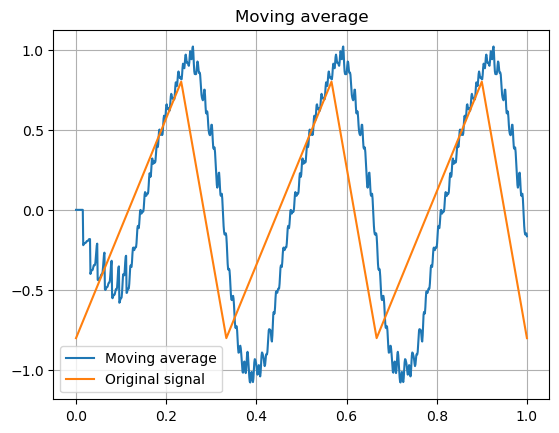

In [25]:
f = FIR_class(taps =8, delay = 16)
filters_run(f.movingAvg, 'Moving average', x, q_test, sawtooth_test(x))

In [ ]:
#